# Code chunks for Microwave Remote Sensing

Welcome to this Jupyter notebook collecting many code chunks that are useful for the MRS UE exercises. It presents typical Python tools for working with geo data, as also used in professional remote sensing. A focus is put on the first exercise, i.e. classifying forests with optical imagery.


## Some Python libraries you might need


A lot of libraries will be used for the exercise, but don't get intimidated by the amout of imports. They mostly fulfill small tasks.

First, we import some popular, useful libraries.


In [16]:
import earthpy.spatial as es
from scipy import signal as sig

import cv2
import datetime
import numpy as np
import pandas as pd
import xarray as xar
import os

Then, we continue with in-house production software for all sorts of data processing. For more information have a look at https://github.com/TUW-GEO.


In [17]:
from geospade.crs import SpatialRef
from veranda.io.geotiff import write_tiff
from veranda.io.geotiff import read_tiff
from geopathfinder.folder_naming import build_smarttree
from geopathfinder.naming_conventions.sgrt_naming import SgrtFilename
from yeoda.products.preprocessed import SIG0DataCube
from yeoda.products.parameter import ParameterDataCube
#from yeoda.products.base import ProductDataCube

Several tasks cannot be solely managed with the existing general-purpose packages. Therefore, we have created a helper package dedicated for this lecture.


In [18]:
from afe.add_ons import generate_tree
from afe.add_ons import OpticalDataCube
from afe.geometry import PolygonCollection
#from afe.dc_add_ons import TMENPLIADataCube

Finally, we import `matplotlib` for interactive plots.


In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

and activate its `widget` backend.


In [20]:
%matplotlib widget
%matplotlib widget

It is generally a good idea to run these widget-commands twice to avoid issues when changing the backend (https://matplotlib.org/2.0.2/faq/usage_faq.html#what-is-a-backend).


To allow for running the code chunks for any user, we can globally define our username here.


In [21]:
USER = os.getcwd().split('/')[
    2]  #This command should automatically get your username
USER

'e12334178'

## Creating the datacube (Sentinel 1)

As we have a bulk of data which occupy quite a few terrabytes of storage space, it would be much too inefficient to simply itterate through the images. To solve this problem we have a yeoda datacube which saves all of the image data in a dataframe like structure, which can be used for managing, filtering and loading bulks of imagery. To learn more about yeoda check out the **yeoda_workshop**.


This section deals with the creation, filtering and handling of sigma naught backscatter (SIG0) and paramter data. `yeoda` offers already datacubes for this kind of tasks, making your life easier.


#### SIG0 Data


One important set of the Sentinel-1 data is the sigma naught backscatter (SIG0) background scatter:

First, we need to define the path to the files, in this example we will use the 10m resolution but you can also use the 500m data:


In [22]:
gen_path = f'/home/{USER}/shared/datasets/fe/data/'
rootpath_sig0 = gen_path + f'sentinel1/preprocessed/EU010M'

Now we need to define our dimensions of interest, these are "stored" in the filename and give information about the data. The ones you see below should be sufficient for your needs, but you can add more according to the field names seen in https://github.com/TUW-GEO/geopathfinder/blob/v0.1.4/src/geopathfinder/naming_conventions/sgrt_naming.py


In [23]:
dimensions_sig0 = [
    "pol", "time", "orbit_direction", "relative_orbit", "tile_name"
]

Next we can create a hierarchical folder tree object.

The `geopathfinder` library can help you to collect all files within the root folder. To do so, you only need to specify the level names below the root folder and a _regex_ pattern for selecting the right files. `geopathfinder`'s `build_smarttree()` function then creates a folder tree object for collecting the files in a recursive manner.


In [24]:
folder_hierarchy = ["tile", "quantity"]
dir_tree_sig0 = build_smarttree(rootpath_sig0,
                                folder_hierarchy,
                                register_file_pattern="^[^Q].*.tif")
filepaths_sig0 = dir_tree_sig0.file_register

Each file name in this dataset follows a certain naming convention, defined and managed by `geopathfinder`'s class `SgrtFilename`.
The list of file paths can then directly be forwarded to `yeoda`'s `SIG0DataCube`, along with the chosen dimensions, the file naming class, and the data encoding attributes (scale factor, no data value, and data type).

**Note:** When loading the 500m data you need to set the parameter `sres` to `500`


In [25]:
dc_sig0 = SIG0DataCube(filepaths=filepaths_sig0,
                       dimensions=dimensions_sig0,
                       filename_class=SgrtFilename,
                       scale_factor=100,
                       nodata=-9999,
                       dtype='int16')

The `inventory` property can be used to view the datacube's content


In [26]:
dc_sig0.inventory

,filepath,pol,time,orbit_direction,relative_orbit,tile_name,var_name
0,/home/e12334178/shared/datasets/fe/data/sentin...,VH,2017-01-01 05:00:55,D,124,E051N016T1,SIG0
1,/home/e12334178/shared/datasets/fe/data/sentin...,VV,2017-01-01 05:00:55,D,124,E051N016T1,SIG0
2,/home/e12334178/shared/datasets/fe/data/sentin...,VH,2017-01-01 16:58:55,A,44,E051N016T1,SIG0
3,/home/e12334178/shared/datasets/fe/data/sentin...,VV,2017-01-01 16:58:55,A,44,E051N016T1,SIG0
4,/home/e12334178/shared/datasets/fe/data/sentin...,VH,2017-01-02 16:50:01,A,146,E051N016T1,SIG0
...,...,...,...,...,...,...,...
18359,/home/e12334178/shared/datasets/fe/data/sentin...,VV,2021-12-27 05:26:33,D,168,E050N016T1,SIG0
18360,/home/e12334178/shared/datasets/fe/data/sentin...,VH,2021-12-29 05:10:37,D,22,E050N016T1,SIG0
18361,/home/e12334178/shared/datasets/fe/data/sentin...,VV,2021-12-29 05:10:37,D,22,E050N016T1,SIG0
18362,/home/e12334178/shared/datasets/fe/data/sentin...,VH,2021-12-30 16:59:46,A,44,E050N016T1,SIG0


#### Parameter Data


To create a datacube for the parameter data we have to use a different datacube class. The parameter data can be manage in the same way as SIG0 backscatter data, but it is averaged data per Orbit.


In [28]:
rootpath_params = gen_path + f'sentinel1/parameters/EU010M'
dir_tree_params = build_smarttree(rootpath_params,
                                  folder_hierarchy,
                                  register_file_pattern="^[^Q].*.tif")
filepaths_params = dir_tree_params.file_register

Again, we can define the dimensions as needed:


In [27]:
dimensions_params = ["relative_orbit", "tile"]

The initialisation works with the `ParameterDataCube` class.


In [29]:
dc_params = ParameterDataCube(filepaths=filepaths_params,
                              dimensions=dimensions_params,
                              filename_class=SgrtFilename,
                              sres=500)
dc_params.inventory

,filepath,relative_orbit,stime,etime,var_name,time,tile_name
0,/home/e12334178/shared/datasets/fe/data/sentin...,22.0,2016-01-01,2017-12-31,TMENSIG0,2016-12-31,E051N016T1
1,/home/e12334178/shared/datasets/fe/data/sentin...,44.0,2016-01-01,2017-12-31,TMENSIG0,2016-12-31,E051N016T1
2,/home/e12334178/shared/datasets/fe/data/sentin...,73.0,2016-01-01,2017-12-31,TMENSIG0,2016-12-31,E051N016T1
3,/home/e12334178/shared/datasets/fe/data/sentin...,95.0,2016-01-01,2017-12-31,TMENSIG0,2016-12-31,E051N016T1
4,/home/e12334178/shared/datasets/fe/data/sentin...,124.0,2016-01-01,2017-12-31,TMENSIG0,2016-12-31,E051N016T1
...,...,...,...,...,...,...,...
604,/home/e12334178/shared/datasets/fe/data/sentin...,22.0,2016-01-02,2017-12-31,TMINSIG0,2016-12-31,E050N016T1
605,/home/e12334178/shared/datasets/fe/data/sentin...,44.0,2016-01-02,2017-12-31,TMINSIG0,2016-12-31,E050N016T1
606,/home/e12334178/shared/datasets/fe/data/sentin...,95.0,2016-01-02,2017-12-31,TMINSIG0,2016-12-31,E050N016T1
607,/home/e12334178/shared/datasets/fe/data/sentin...,146.0,2016-01-02,2017-12-31,TMINSIG0,2016-12-31,E050N016T1


## Creating the datacube (Sentinel 2)


As with the Sentinel-1 data we can also create a datacube for Sentinel-2 data, again with a different datacube class, in contrast to the Sentinel-1 data we do not need to define a folder hierarchy and register file pattern. Also the dimensions do not have to be defined.


In [30]:
root_dirpath_s2 = gen_path + f'sentinel2/L2A/EU010M'
dir_tree_s2 = generate_tree(root_dirpath_s2)
filepaths_s2 = dir_tree_s2.file_register

The initialisation works with the `OpticalDataCube` class.


In [31]:
dc_s2 = OpticalDataCube(filepaths=filepaths_s2)
dc_s2.inventory

,filepath,var_name,time,tile_name
0,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-01,E051N016T1
1,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-04,E051N016T1
2,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-11,E051N016T1
3,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-14,E051N016T1
4,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-18,E051N016T1
...,...,...,...,...
34051,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-14,E050N016T1
34052,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-17,E050N016T1
34053,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-21,E050N016T1
34054,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-27,E050N016T1


## Filtering the Datacube


The datacube has all the available data saved, as we don't need every single file we can filter the datacube to only contain the files we are interested in.
There are five ways to filter the datacube:

-   `filter_by_dimension`
-   `filter_by_metadata`
-   `filter_files_with_pattern`
-   `filter_spatially_by_geom`
-   `filter_spatially_by_tilename`

Every one of these commands has the keyword `inplace` if this is set to `True` the datacube will be overwritten with the filtered data, if it is set to `False` a new datacube is created containing the filtered data. By deafault it is set to `False`.

For the Sentinel-1 and -2 data there are a few tiles available each stretching across an 100x100km area.

<img src="Tiles.png" width="594" height="420" align="center">


For this example we will use the datacube for the Sentinel-2 data. We can filter the datacube according to the tile "E052N015T1" with the `filter_spatially_by_tilename` function. Beware that the `inplace` key-word specifies, if the datacube should be overwritten (`=True`) or not (`=False`).


In [32]:
tile = "E052N015T1"
dc_s2.filter_spatially_by_tilename(tile, inplace=True)
dc_s2.inventory

,filepath,var_name,time,tile_name
0,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-01,E052N015T1
1,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-04,E052N015T1
2,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-08,E052N015T1
3,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-11,E052N015T1
4,/home/e12334178/shared/datasets/fe/data/sentin...,B11,2017-01-14,E052N015T1
...,...,...,...,...
5428,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-11-01,E052N015T1
5429,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-08,E052N015T1
5430,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-18,E052N015T1
5431,/home/e12334178/shared/datasets/fe/data/sentin...,TCI,2021-12-21,E052N015T1


Note that we now only have 5433 entries instead of 34055.


With the `filter_by_dimension` function we can filter for any available dimension, for example we can filter a specific time period or spectral bands. For Sentinel-1 data we could also filter after the polarisation, relative orbit or, in case of parameter data, the type of parameter.


In [33]:
spectral_bands = dc_s2.SPECTRAL_BANDS
dc_s2.filter_by_dimension(
    [(datetime.date(2017, 3, 1), datetime.date(2017, 6, 1))],
    expressions=[('>', '<=')],
    name='time',
    inplace=True)
dc_s2.filter_by_dimension(["B02", "B03", "B04", "B08"],
                          name="var_name",
                          inplace=True)
dc_s2.inventory

,filepath,var_name,time,tile_name
0,/home/e12334178/shared/datasets/fe/data/sentin...,B02,2017-03-05,E052N015T1
1,/home/e12334178/shared/datasets/fe/data/sentin...,B02,2017-03-09,E052N015T1
2,/home/e12334178/shared/datasets/fe/data/sentin...,B02,2017-03-12,E052N015T1
3,/home/e12334178/shared/datasets/fe/data/sentin...,B02,2017-03-15,E052N015T1
4,/home/e12334178/shared/datasets/fe/data/sentin...,B02,2017-03-25,E052N015T1
...,...,...,...,...
79,/home/e12334178/shared/datasets/fe/data/sentin...,B08,2017-05-11,E052N015T1
80,/home/e12334178/shared/datasets/fe/data/sentin...,B08,2017-05-14,E052N015T1
81,/home/e12334178/shared/datasets/fe/data/sentin...,B08,2017-05-18,E052N015T1
82,/home/e12334178/shared/datasets/fe/data/sentin...,B08,2017-05-24,E052N015T1


## Creating the datacube (NDVI)


We can also create a datacube for the Copernicus NDVI data:


In [34]:
root_dirpath_ndvi = gen_path + f'auxiliary_data/copernicus_ndvi/EU500M'
dir_tree_ndvi = build_smarttree(root_dirpath_ndvi,
                                folder_hierarchy,
                                register_file_pattern="^[^Q].*.tif")
filepaths_ndvi = dir_tree_ndvi.file_register
dimensions_ndvi = ["time", "tile"]

In [35]:
#dc_ndvi = ProductDataCube(filepaths=filepaths_ndvi, dimensions=dimensions_ndvi, filename_class=SgrtFilename)
#dc_ndvi.inventory

## Loading the files into memory


To get the data inside of the files we need to load them into memory. Again there is more than one way to do this:

-   `load_available_bands_by_geom`
-   `load_available_bands_by_pixels`
-   `load_by_coords`

If you want to load a simple rectangular view of your data `load_available_bands_by_pixels(col, row, col_size, row_size)` does the job perfectly fine. Loading more complex geometries (polygons) can be done with ogr type polygons.

To cut the 100x100km tile to an 8x8km area. We can do this by defining the upper left corner and the height and width of the area. (Note: this is in pixels relative to the top left corner of the tile). Beware that row refers to the x-axis and col to the y-axis. Have a look at the Quicklooks to see where your area is.


In [36]:
ul_col, ul_row = 4800, 900  # The upper left corner of the area relative to the tile
col_size, row_size = 800, 800  # The extent of the area [in pixels]

In [37]:
data = dc_s2.load_available_bands_by_pixels(ul_col, ul_row, col_size, row_size)
data

<xarray.Dataset>
Dimensions:  (time: 21, y: 800, x: 800)
Coordinates:
  * time     (time) object 2017-03-05 2017-03-09 ... 2017-05-24 2017-05-28
  * y        (y) float64 1.552e+06 1.552e+06 1.552e+06 ... 1.544e+06 1.544e+06
  * x        (x) float64 5.209e+06 5.209e+06 5.209e+06 ... 5.217e+06 5.217e+06
Data variables:
    B02      (time, y, x) float64 nan nan nan nan ... 0.0279 0.0264 0.0264
    B03      (time, y, x) float64 nan nan nan nan ... 0.0744 0.0733 0.0733
    B04      (time, y, x) float64 nan nan nan nan ... 0.0317 0.0327 0.033 0.033
    B08      (time, y, x) float64 nan nan nan nan ... 0.49 0.5041 0.5073 0.5073

**Note:** In case of **Sentinel-1** Datacubes the functions for loading are called:

-   `load_by_geom`
-   `load_by_pixels`
-   `load_by_coords`

These functions work the same but you can specify the parameter `dtype` with which you can define in what datastructure (`xarray`=xarray or `numpy`=np.array) you want to load the data.


We can filter out any time periods where exclusively nan-Values appear in all of the variables by calling the `.dropna` function and sort our data chronologically.


In [38]:
data = data.dropna(dim="time", how="all")
data = data.sortby("time")
data

<xarray.Dataset>
Dimensions:  (time: 7, y: 800, x: 800)
Coordinates:
  * time     (time) object 2017-03-09 2017-03-29 ... 2017-05-18 2017-05-28
  * y        (y) float64 1.552e+06 1.552e+06 1.552e+06 ... 1.544e+06 1.544e+06
  * x        (x) float64 5.209e+06 5.209e+06 5.209e+06 ... 5.217e+06 5.217e+06
Data variables:
    B02      (time, y, x) float64 0.9218 0.8181 0.7012 ... 0.0279 0.0264 0.0264
    B03      (time, y, x) float64 0.8937 0.7862 0.6995 ... 0.0744 0.0733 0.0733
    B04      (time, y, x) float64 0.8933 0.788 0.6923 ... 0.0327 0.033 0.033
    B08      (time, y, x) float64 0.9621 0.8527 0.7432 ... 0.5041 0.5073 0.5073

What you get here is a data structure called `xarray` (https://xarray.pydata.org), featuring spatial (`x`, `y`) and temporal (`time`) coordinates. For each of these coordinates a set of data variables is defined. You can use most functions which you can also use with `numpy` (for example `.mean` or `.dropna` lika above) but you should define a dimension over which it should be calculated. Also you can extract the data of a single variable as a `np.array` with the `.values` function.


In [39]:
data.mean(dim="time")

<xarray.Dataset>
Dimensions:  (y: 800, x: 800)
Coordinates:
  * y        (y) float64 1.552e+06 1.552e+06 1.552e+06 ... 1.544e+06 1.544e+06
  * x        (x) float64 5.209e+06 5.209e+06 5.209e+06 ... 5.217e+06 5.217e+06
Data variables:
    B02      (y, x) float64 0.2258 0.212 0.1913 0.1787 ... 0.1481 0.1485 0.1485
    B03      (y, x) float64 0.2338 0.22 0.1981 0.1872 ... 0.1737 0.1728 0.1728
    B04      (y, x) float64 0.2311 0.208 0.1875 0.1765 ... 0.1596 0.1563 0.1563
    B08      (y, x) float64 0.3702 0.36 0.3479 0.3258 ... 0.449 0.4438 0.4438

In [40]:
data["B02"].values

array([[[0.9218, 0.8181, 0.7012, ..., 0.7612, 0.7453, 0.7374],
        [0.885 , 0.7769, 0.6775, ..., 0.7497, 0.7391, 0.731 ],
        [0.885 , 0.7744, 0.6844, ..., 0.7396, 0.7267, 0.7189],
        ...,
        [0.0522, 0.0473, 0.0347, ..., 0.6736, 0.6844, 0.712 ],
        [0.0499, 0.0457, 0.038 , ..., 0.6662, 0.6684, 0.6849],
        [0.0544, 0.0519, 0.0485, ..., 0.6729, 0.6816, 0.6816]],

       [[0.0666, 0.0618, 0.0573, ..., 0.6008, 0.5723, 0.5597],
        [0.0641, 0.0579, 0.05  , ..., 0.6063, 0.5618, 0.5099],
        [0.0579, 0.0533, 0.0492, ..., 0.5739, 0.5324, 0.4746],
        ...,
        [0.0648, 0.0682, 0.0596, ..., 0.071 , 0.0657, 0.0595],
        [0.0711, 0.0743, 0.067 , ..., 0.083 , 0.0727, 0.0662],
        [0.0751, 0.0726, 0.0741, ..., 0.0751, 0.0757, 0.0757]],

       [[0.0314, 0.0302, 0.024 , ..., 0.0108, 0.0079, 0.0064],
        [0.0251, 0.025 , 0.0312, ..., 0.0083, 0.0089, 0.0087],
        [0.0293, 0.0186, 0.0351, ..., 0.0094, 0.0066, 0.0072],
        ...,
        [0.0

## Loading and writing single tiff images


### Loading


If you want to read a tiff file directly you can use the `read_tiff` function. The return of the function is a tuple with the data as a `np.array` and a `dict` with the tags.


In [41]:
src = gen_path + f'sentinel1/preprocessed/EU010M/E048N015T1/sig0/D20170111_051741--_SIG0-----_S1BIWGRDH1VVD_095_A0105_EU010M_E048N015T1.tif'

In [42]:
src_arr, tags_dict = read_tiff(src)
src_arr

array([[-9999, -9999, -9999, ..., -1329, -1200,  -877],
       [-9999, -9999, -9999, ..., -1380, -1254, -1159],
       [-9999, -9999, -9999, ..., -1281, -1149, -1216],
       ...,
       [-9999, -9999, -9999, ..., -1476, -1126,  -988],
       [-9999, -9999, -9999, ..., -1409, -1198, -1082],
       [-9999, -9999, -9999, ..., -1513, -1228, -1146]], dtype=int16)

**Note:** When reading data this way it doesnt account for a possible scaling factor or offset, also the no data values are mostly masked. To find out these factors you can look inside the tags dictionary:


In [43]:
tags_dict

{'description': '/home/e12334178/shared/datasets/fe/data/sentinel1/preprocessed/EU010M/E048N015T1/sig0/D20170111_051741--_SIG0-----_S1BIWGRDH1VVD_095_A0105_EU010M_E048N015T1.tif',
 'metadata': {'abs_orbit_number': '003796',
  'AREA_OR_POINT': 'Area',
  'band_1': 'Sigma0_VV',
  'border_noise_removed': 'True',
  'creator': 'TUWGEO',
  'distanceuom': 'm',
  'distancevalue': '10',
  'equi7_tile': 'EU010M_E048N015T1',
  'ext_dem': '/eodc/private/tuwgeo/users/acube/data/input/acube_dem_eh.tif',
  'grid': 'Equi7 Grid',
  'gtc_applied': 'True',
  'log_file': 'tasklist_18_A01_sig0_jobfile_A0105_log_20200506_144914.xml',
  'orbit_aux_file': 'POE',
  'parent_data_file': 'S1B_IW_GRDH_1SDV_20170111T051741_20170111T051806_003796_006869_3F95.zip',
  'polarisation': 'VV',
  'precise_orbit_applied': 'True',
  'processing_date': '2020-05-06 14:53:09',
  'processing_software': 'SGRT',
  'processing_software_version': 'A0105-2.4.9.post.dev6.pre',
  'rel_orbit_number': '095',
  'sat_product_id': 'S1BIWGRDH

You can see that the scaling factor is 100 and the no data values -9999 so we can account for that:


In [44]:
data_in = np.where(src_arr == -9999, np.nan, src_arr / 100)
data_in

array([[   nan,    nan,    nan, ..., -13.29, -12.  ,  -8.77],
       [   nan,    nan,    nan, ..., -13.8 , -12.54, -11.59],
       [   nan,    nan,    nan, ..., -12.81, -11.49, -12.16],
       ...,
       [   nan,    nan,    nan, ..., -14.76, -11.26,  -9.88],
       [   nan,    nan,    nan, ..., -14.09, -11.98, -10.82],
       [   nan,    nan,    nan, ..., -15.13, -12.28, -11.46]])

### Writing


If you want to write a single tiff file you can use the `write_tiff` function by defining a destination path, the data array and a tags dict. To optimise for storage space you can encode your array, by scaling it and masking the nan values:


In [45]:
dst_arr = np.where(np.isnan(data_in), -9999, data_in * 100)

Don't forget to change the datatype:


In [46]:
dst_arr = dst_arr.astype("int16")
dst_arr

array([[-9999, -9999, -9999, ..., -1329, -1200,  -877],
       [-9999, -9999, -9999, ..., -1380, -1254, -1159],
       [-9999, -9999, -9999, ..., -1281, -1149, -1216],
       ...,
       [-9999, -9999, -9999, ..., -1476, -1126,  -988],
       [-9999, -9999, -9999, ..., -1409, -1198, -1082],
       [-9999, -9999, -9999, ..., -1513, -1228, -1146]], dtype=int16)

In [47]:
dst_path = os.getcwd() + '/new_tiff_file.tif'
print(dst_path)
tags_dst = tags_dict
write_tiff(dst_path, src_arr=dst_arr, tags_dict=tags_dst)

/home/e12334178/new_tiff_file.tif


**Note:** If you want to save a rgb image you can use the parameters `red`, `green` and `blue` for the respective values in the `write_tiff` function instead of the `src_arr`.


## Image processing


In case of Sentinel-2 images we can process the image to create rgb images, false color images and increase contrast:


### Stacking


To properly display an image we need to firstly pick one specific dataset out of our loaded xarray.


In [48]:
single_image = data.sel(time=datetime.date(2017, 4, 1))

With the xarray created by loading the Sentinel 2 data we cannot just yet create a meaningful image. As we have already seen in the loaded xarray we have nine different bands available for each time, x and y-coordinate.

-   B02: Blue
-   B03: Green
-   B04: Red
-   B05: Vegetation red edge
-   B06: Vegetation red edge
-   B07: Vegetation red edge
-   B08: NIR
-   B11: SWIR
-   B12: SWIR

We have to extract the bands we need from our xarray in order to create an rgb-image. To do this we have to stack the concerned bands with the function `np.stack`:


In [49]:
b02 = single_image['B02'].values  #blue values
b03 = single_image['B03'].values  #green values
b04 = single_image['B04'].values  #red values

rgb_raw = np.stack([b04, b03, b02], axis=2)

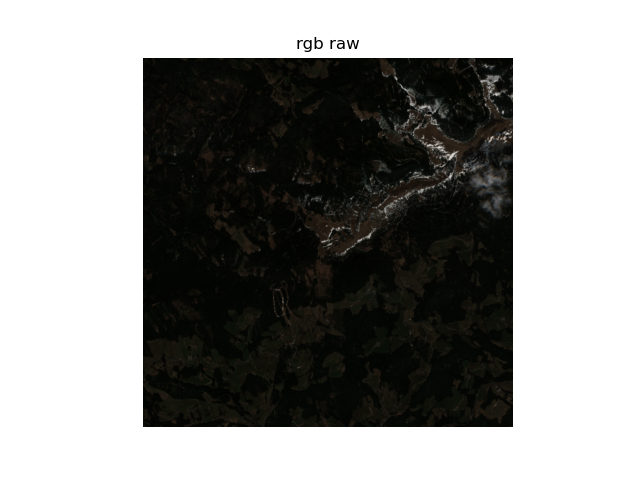

In [50]:
fig, ax = plt.subplots()
ax.imshow(rgb_raw)
ax.set_title("rgb raw")
ax.set_axis_off()

As you can clearly see the contrast of the image is very low, which makes it appear dark.


### Histogram


It is very helpful creating a histogram for your images. A histogram shows the distribution of your pixel values in regards to their color intenensity, meaning low intensities bring dark pixels (black=0) and high intensities bright pixels (white=1).

To create a histogram you can use the `hist()` function. Be careful as it only accepts one dimensional arrays. The dimension of an array can be reduced using the `flatten()` function. As we want to show the distribution for each band seperately we have to extract the bands from the rgb-image first.


In [51]:
def plot_rgb_histogram(rgb_im, ax, title, bins=300):
    mbins = np.linspace(np.nanmin(rgb_im), np.nanmax(rgb_im), bins)
    ax.hist(rgb_im[:, :, 2].flatten(), color='blue', bins=mbins, alpha=0.5)
    ax.hist(rgb_im[:, :, 1].flatten(), color='green', bins=mbins, alpha=0.5)
    ax.hist(rgb_im[:, :, 0].flatten(), color='red', bins=mbins, alpha=0.5)

    ax.set_title(title)
    ax.set_xlabel('I')
    ax.set_ylabel('n')

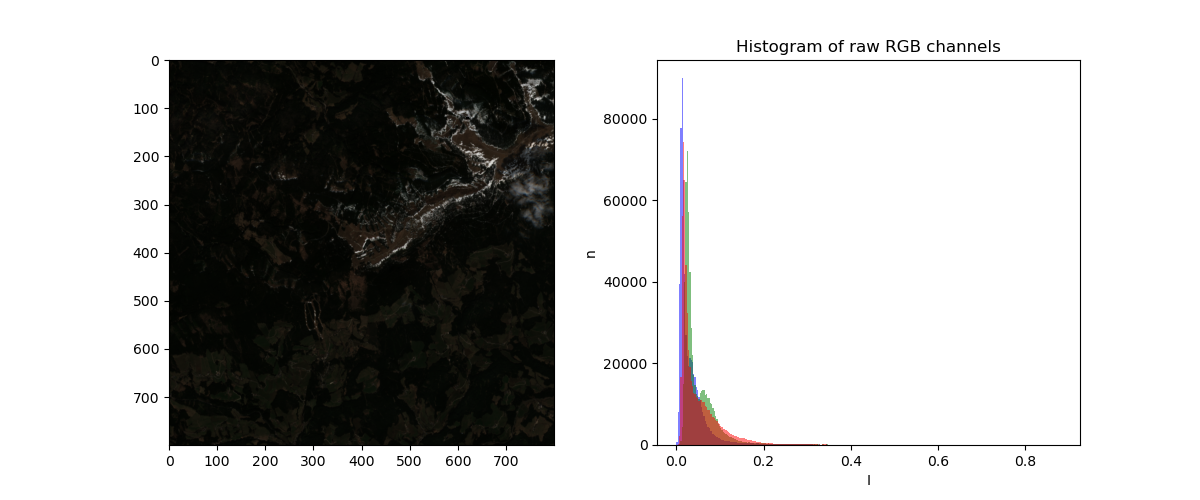

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_rgb_histogram(rgb_raw, ax[1], 'Histogram of raw RGB channels', bins=300)
ax[0].imshow(rgb_raw)
plt.show()

You can see, that the intensity of the rgb values is very low, which makes it appear dark.


### Contrast


To fix this problem we can increase the contrast of the image. To do this we implement the following functions, which will be needed for processing your image. For more details on how these functions work and why we need them to increase contrast and correctly encode the data, take a look at https://www.cg.tuwien.ac.at/courses/EinfVisComp/Skriptum/SS13/EVC-11%20Point%20Operations.pdf for a great overview.


In [53]:
def auto_clip(I, percentile=0.02, pooled=True):
    """
    Calculates the quantiles of I using the percentile parameter and clips the values using the clip function defined below.

    Modifies I

    Parameters
    ----------
    I : np.array(rows, cols, bands)
        Image array.
    percentile : float, optional
        Percentile defining the clipping boundaries of I in terms of its distribution (defaults to 0.02).
    pooled: if True, computes the pooled percentile over all band
            (default, use this to keep the relative intensities of the bands for natural looking images)
            if False, computes the percentiles for each band individually
            (use this - in conjunction with stretch - to bring the different bands into a comparable range, e.g. for false colour images)


    Returns
    -------
    np.array :
        Auto-clipped image data.

    """
    if pooled:
        v_min = np.nanquantile(I, percentile)
        v_max = np.nanquantile(I, 1 - percentile)

    else:
        tmp = I.reshape(
            -1, I.shape[-1])  #collapes image x,y 2d-array into a 1d-array
        v_min = np.nanquantile(tmp, percentile, axis=0)
        v_max = np.nanquantile(tmp, 1 - percentile, axis=0)

    return clip(I, v_min, v_max)


def clip(I, v_min, v_max):
    """
    Performs clipping (dt. "Histogrammbegrenzung")
    Sets all values in I that are outside of [v_min, v_max] to the corresponding boundary.


    Modifies I

    Parameters
    ----------
    I : np.array
        Image array.
    v_min : scalar or array
        Lower clipping boundary for each band
    v_max : scalar or array
        lower clipping boundary for each band

    Returns
    -------
    np.array :
        Clipped image data.

    """

    tmp = I.reshape(-1,
                    I.shape[-1])  #collapes image x,y 2d-array into a 1d-array
    if np.isscalar(v_min):
        tmp[tmp < v_min] = v_min
        tmp[tmp > v_max] = v_max
    else:
        idx = np.where(tmp < v_min)
        tmp[idx] = v_min[idx[1]]
        idx = np.where(tmp > v_max)
        tmp[idx] = v_max[idx[1]]

    return I


def stretch(I, p_min, p_max, pooled=True):
    """
    Performs histogram stretching or normalisation (dt. "Spreizung")
    Computes and applies an affine transformation of values in I to the range [p_min, p_max].
    For floating point images to be displayed with pylab.imshow(), p_min=0, p_max=1
    should be chosen.

    Modifies I

    Parameters
    ----------
    I : np.array
        Image array.
    p_min : number
        Lower boundary of the output range.
    p_max : number
        Upper  boundary of the output range.
    pooled: if True, the transformation is computed for and applied to all bands simultaneously
            if False, -"- to the individual bands separately
    Returns
    -------
    np.array :
        Normalised image data within the range [p_min, p_max].

    """

    tmp = I.reshape(-1,
                    I.shape[-1])  #collapes image x,y 2d-array into a 1d-array

    if pooled:
        q_min = np.nanmin(I)
        q_max = np.nanmax(I)

    else:

        q_min = np.nanmin(tmp, axis=0)
        q_max = np.nanmax(tmp, axis=0)

    tmp[:] = (p_max - p_min) * (tmp - q_min) / (q_max - q_min) + p_min
    return I

First we can use the `auto_clip()` or `clip()` function to set values of intensity which are outside of a boundary to the boundary border:


In [54]:
rgb_clipped = auto_clip(rgb_raw.copy(), percentile=0.05, pooled=True)

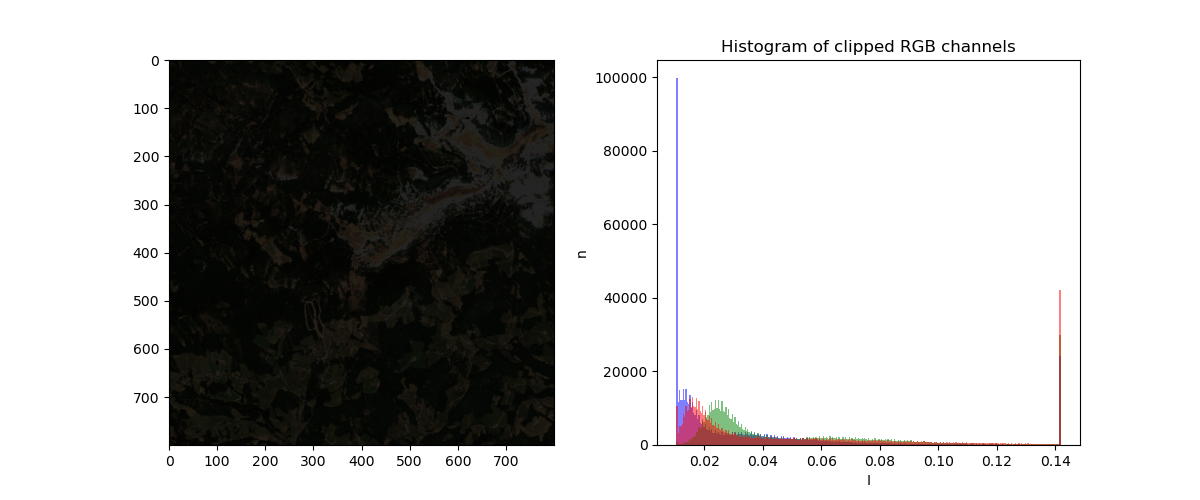

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_rgb_histogram(rgb_clipped,
                   ax[1],
                   'Histogram of clipped RGB channels',
                   bins=300)
ax[0].imshow(rgb_clipped)
plt.show()

You can see that the histogram now has clear borders, and all the values below/above these borders have been set to the border values. You can play around clipping fewer/more values by setting the percentile value in the `auto_clip()` function. The `pooled` parameter sets if the bands get clipped individually (`=FALSE`) or as a group (`=TRUE`).

As the intensity of the values is still too low after clipping we have to stretch the values to spread between 0 and 1. We can do this by using the `stretch()` function.


In [56]:
rgb_clipped_stretched = stretch(rgb_clipped.copy(), 0, 1, pooled=True)

Again, we can extract the bands, flatten them and create a histogram. Also we will compare the histogram to the raw image, the only clipped image and an only stretched image:


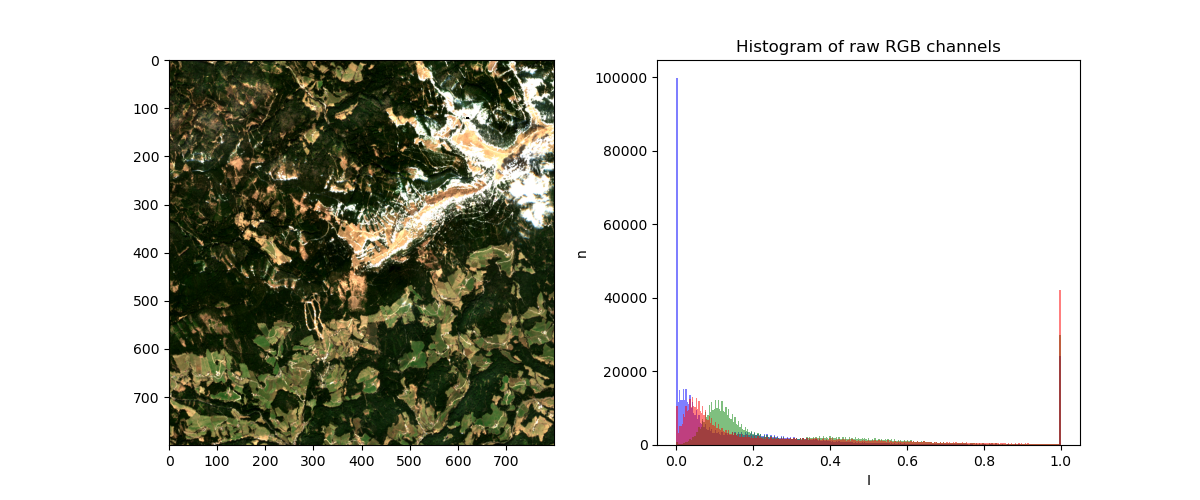

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_rgb_histogram(rgb_clipped_stretched,
                   ax[1],
                   'Histogram of raw RGB channels',
                   bins=300)
ax[0].imshow(rgb_clipped_stretched)
plt.show()

In [ ]:
rgb_stretched = stretch(rgb_raw.copy(), 0, 1)

NameError: name 'rgb_stretched' is not defined

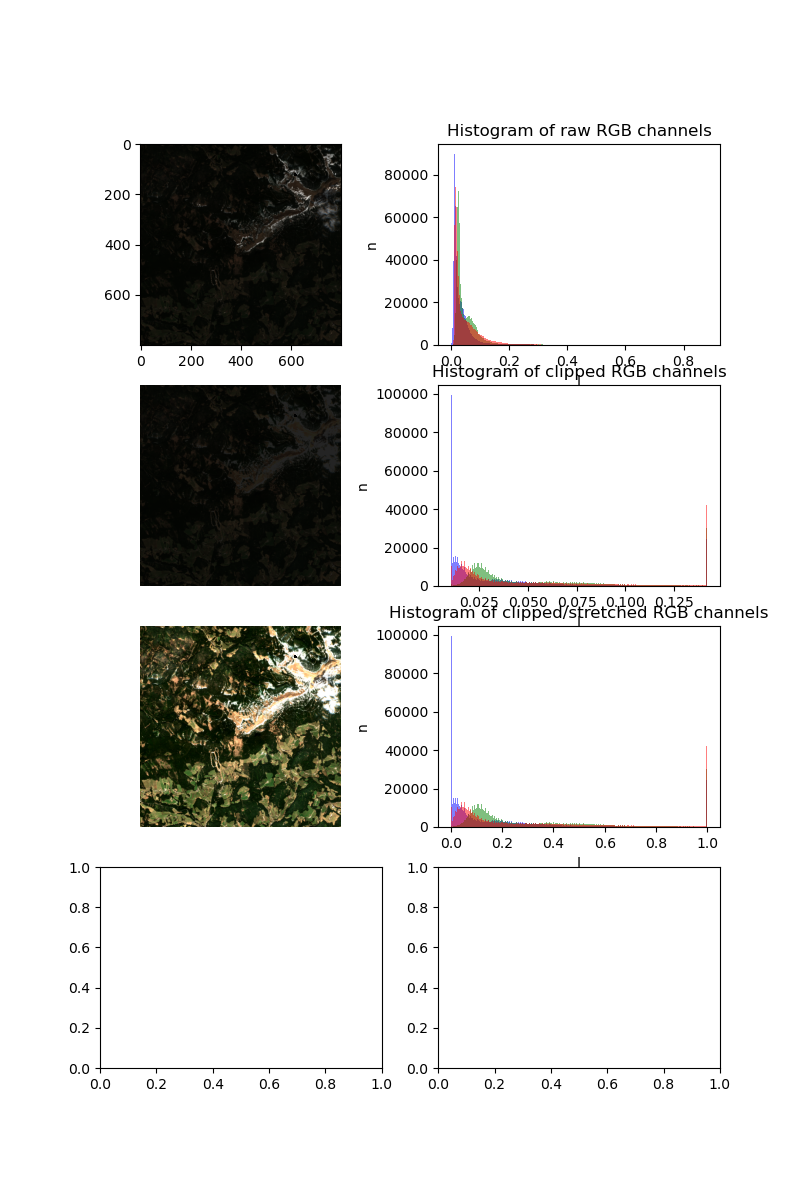

In [58]:
fig, ax = plt.subplots(4, 2, figsize=(8, 12))
plot_rgb_histogram(rgb_raw,
                   ax[0, 1],
                   'Histogram of raw RGB channels',
                   bins=300)
ax[0, 0].imshow(rgb_raw)
#ax[0,0].set_axis_off()

plot_rgb_histogram(rgb_clipped,
                   ax[1, 1],
                   'Histogram of clipped RGB channels',
                   bins=300)
ax[1, 0].imshow(rgb_clipped)
ax[1, 0].set_axis_off()

plot_rgb_histogram(rgb_clipped_stretched,
                   ax[2, 1],
                   'Histogram of clipped/stretched RGB channels',
                   bins=300)
ax[2, 0].imshow(rgb_clipped_stretched)
ax[2, 0].set_axis_off()

plot_rgb_histogram(rgb_stretched,
                   ax[3, 1],
                   'Histogram of stretched RGB channels',
                   bins=300)
ax[3, 0].imshow(rgb_stretched)
ax[3, 0].set_axis_off()

plt.tight_layout()
plt.show()

Now we have a good distribution of the values between 0 and 1 and should receive a clear image when plotting.


In [ ]:
fig, ax = plt.subplots()
ax.imshow(rgb_clipped_stretched)
ax.set_title("rgb clipped stretched")
ax.set_axis_off()

If the final image doesnt look natural or still seems too dark try playing around with the percentile value or set the intensity value manually with the `clip()` function instead of `auto_clip()`. If an individual band has a much higher intensity compared to the others try setting `pooled` to `=FALSE` when clipping and stretching.

You can also use `np.log()` on the raw rgb image before clipping and stretching it to increase contrast.

You can see what happens when we play around with the `percentile` parameter in the `auto_clip` function or use the `np.log` function below:


In [ ]:
rgb_clipped_stretched_01 = stretch(auto_clip(rgb_raw.copy(), percentile=0.01),
                                   0, 1)
rgb_clipped_stretched_05 = stretch(auto_clip(rgb_raw.copy(), percentile=0.05),
                                   0, 1)
rgb_clipped_stretched_15 = stretch(auto_clip(rgb_raw.copy(), percentile=0.15),
                                   0, 1)
rgb_clipped_stretched_log = stretch(
    auto_clip(np.log(rgb_raw.copy()), percentile=0.05), 0, 1)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(rgb_clipped_stretched_01)
ax[0, 0].set_title("percentile = 0.01")
ax[0, 1].imshow(rgb_clipped_stretched_05)
ax[0, 1].set_title("percentile = 0.05")
ax[1, 0].imshow(rgb_clipped_stretched_15)
ax[1, 0].set_title("percentile = 0.15")
ax[1, 1].imshow(rgb_clipped_stretched_log)
ax[1, 1].set_title("log and percentile = 0.05")

### False color image


As we want to analyze our picture regarding forested areas, we can make this easier using a false color image. Vegetetation reflects light in much higher intensities in the near infrared side of the spectrum. To visualize this we can replace the red band in the rgb image with the NIR band (=band 8)


In [ ]:
b02 = single_image['B02'].values  #blue values
b03 = single_image['B03'].values  #green values
b08 = single_image['B08'].values  #NIR values

fc_img = np.stack([b08, b03, b02], axis=2)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(fc_img)
ax[0].set_title("false-color image")
ax[0].set_axis_off()
plot_rgb_histogram(fc_img, ax[1], 'Histogram of false-color image', bins=300)


We can see that the NIR values are slightly higher than the ones of the green and blue band. So this time we will change the `pooled` parameter to `False` when incresing the contrast. You can also see the difference when the `pooled` parameter is set to `True`.


In [ ]:
fc_img_clipped_stretched_false = stretch(auto_clip(np.log(fc_img.copy()),
                                                   pooled=False),
                                         0,
                                         1,
                                         pooled=False)

fc_img_clipped_stretched_true = stretch(auto_clip(np.log(fc_img.copy()),
                                                  percentile=0.005,
                                                  pooled=True),
                                        0,
                                        1,
                                        pooled=True)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(fc_img_clipped_stretched_false)
ax[0, 0].set_title("false-color image clipped stretched\npooled=False")
ax[0, 0].set_axis_off()

plot_rgb_histogram(fc_img_clipped_stretched_false,
                   ax[0, 1],
                   'Histogram pooled=False',
                   bins=300)

ax[1, 0].imshow(fc_img_clipped_stretched_true)
ax[1, 0].set_title("false-color image clipped stretched\npooled=True")
ax[1, 0].set_axis_off()

plot_rgb_histogram(fc_img_clipped_stretched_true,
                   ax[1, 1],
                   'Histogram pooled=True',
                   bins=300)


## Cloud filtering


In this part of the task, we want to filter out any visible clouds. For this we need images from five consecutive dates, so be sure that your xarray has data from at least five different dates.


In [ ]:
data.time

We will choose the dates 1.4, 21.4, 11.5, 18.5 and 28.5.2017 for our example


In [ ]:
time = data.time[2:]
consecutive_imgs = data.sel(time=time)
consecutive_imgs

We now stack and increase the contrast of every image, and plot the results.


In [ ]:
imgs = []
i = 0
for i in range(5):
    img = consecutive_imgs.sel(time=consecutive_imgs.time[i])
    b02 = img['B02'].values
    b03 = img['B03'].values
    b04 = img['B04'].values
    rgb_raw = np.stack([b04, b03, b02], axis=2)
    rgb = stretch(auto_clip(np.log(rgb_raw)), 0, 1)
    imgs.append(rgb)
    i += 1

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax = ax.ravel()
i = 0

for img in imgs:
    ax[i].imshow(img)
    ax[i].set_axis_off()
    ax[i].set_title(consecutive_imgs.time[i].values)
    i += 1

ax[5].axis("off")

Now we can calculate the median pixel value from these images to receive a cloudless image.


In [ ]:
cloudfree_img_data = consecutive_imgs.median(dim="time")

In [ ]:
b02 = cloudfree_img_data['B02'].values
b03 = cloudfree_img_data['B03'].values
b04 = cloudfree_img_data['B04'].values

cloudfree_img_raw = np.stack([b04, b03, b02], axis=2)
cloudfree_img = stretch(auto_clip(np.log(cloudfree_img_raw)), 0, 1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cloudfree_img)
ax.set_title("Cloudfree image")
ax.set_axis_off()

## NDVI


NDVI and many other indices rely on the normalized difference, represented by the function below


In [ ]:
def normalized_difference(a, b):
    return (a - b) / (a + b)

To get the ndvi we need to calculate the normalized difference between the infrared (B08) and the red (B04) band.


In [ ]:
ndvi_img = normalized_difference(cloudfree_img_data["B08"].values,
                                 cloudfree_img_data["B04"].values)

We can plot the result:


In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("NDVI")
im = ax.imshow(ndvi_img, cmap="RdYlGn")
ax.set_axis_off()
plt.colorbar(im)

NDVI does a good job seperating vegetation from non-vegetation but it can't seperate forest from vegetated cropland, or grassland.


## Creating custom colormaps


Creating custom colormaps, can be helpful to visualise and analyse classification outcomes. `matplotlib`'s `ListedColormap` allows you to create a colormap from a list containing `n` colors.

**Hint:** Using RGBA values for colors, some pixels can be set to be fully transparent. This can be useful if you want to overlay two images. You might also want to take a look at the `set_under` and `set_over` methods of colormaps.


In [ ]:
cmap = colors.ListedColormap(['red', 'blue', 'turquoise', 'white'])

The value ranges referring to each of the colors must be specified in a second array with a length of `n+1` defining the upper and lower value boundary allocated to a certain color.


In [ ]:
bounds = np.array([-1000, -12, -8, -6, 0])

We can also add labels for the ticks and change their location:


In [ ]:
labels = ['red', 'blue', 'turquoise', 'white']
tick_location = [-500, -10, -7, -3]

The number of elements in the colormap `cmap.N` and the class boundaries can then be used to create an object for normalising the values to 0 and 1.


In [ ]:
norm = colors.BoundaryNorm(bounds, cmap.N)

Now we can plot an image with the discrete colormap of our choice. For this Example we will use our previously loaded single tiff image.


In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
img_col = ax.imshow(data_in, cmap=cmap, norm=norm)

cbar = plt.colorbar(img_col,
                    ax=ax,
                    boundaries=bounds,
                    ticks=tick_location,
                    shrink=0.65,
                    orientation='horizontal')
cbar.set_label('Sigma nought backscatter')
cbar.set_ticklabels(labels)

## DEM


First, we need to locate where the digital elevation model (DEM) data is stored and select a file of interest (10000x10000 pixels).


In [ ]:
dem_path = gen_path + f'auxiliary_data/dem/srtm_vfp/EU010M/{tile}/SRTM_VFP_EU010M_{tile}.tif'

Then we can load it with `read_tiff` as a `numpy` array. The first return value is the data, the second metadata tags, which we do not need now.


In [ ]:
dem, _ = read_tiff(dem_path)

Then we select elevation data for a specific region of interest.


In [ ]:
elevation = dem[ul_col:ul_col + col_size, ul_row:ul_row + row_size]

Next, we can create a hillshade from the selected elevation data. The `earthpy` library features a function for hillshading that takes elevation data, and an azimuth and altitude value defining the source of illumination. Note that for larger arrays, this operation might take a while. Hillshade is used for visualisation purposes. An azimuth of 0/360 means the illumination is from northern, an azimuth of 180 means it is from southern direction.


In [ ]:
hillshade1 = es.hillshade(elevation, azimuth=45, altitude=20)

In order to compute the aspect (orientation) of the surfaces, we compute the first derivative in north-south direction, which is realised by convoluting DEM data with a vertical Sobel kernel.


In [ ]:
sob_v = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype='int32')
gradx = sig.convolve2d(elevation, sob_v, mode='same') / 8

Finally, we can plot the created hillshade.


In [ ]:
cmap = colors.ListedColormap(["grey", 'yellow'])

fig = plt.figure(figsize=(11, 8))
ax0 = plt.subplot(231)
ax1 = plt.subplot(232)
ax2 = plt.subplot(233)

ax0.set_title('Elevation in m')
el_img = ax0.imshow(elevation, cmap="gist_earth")
fig.colorbar(el_img, ax=ax0, shrink=0.75, orientation='horizontal')
ax1.set_title('Hillshade 45 AZ')
hs_img = ax1.imshow(hillshade1, cmap="Greys_r", vmin=0, vmax=255)
ax2.set_title('Nord-Süd Gradient')
hs_img = ax2.imshow(gradx, vmin=-10, vmax=10)

ax3 = plt.subplot(234)
ax4 = plt.subplot(235)
ax5 = plt.subplot(236)

ax3.set_title('southern facing slope')
ax3.imshow(gradx > 2, cmap=cmap)
ax4.set_title('northern facing slope')
ax4.imshow(gradx < -2, cmap=cmap)
ax5.set_title('no north-south facing slope')
hs_img = ax5.imshow(np.abs(gradx) < 2, cmap=cmap)

## 500m Daten


The following code is an example to demonstrate the differences in code when using on 500m data.
In order to better understand the Tiling Convention it migth be adviseable to have a look at the following PowerPoint.
https://cartography.tuwien.ac.at/eurocarto/wp-content/uploads/2015/09/3_6_ppt.pdf Especially the pages 12 to 17 should help you.


In [ ]:
rootpath_sig0_500m = gen_path + f'sentinel1/preprocessed/EU500M'
dimensions_sig0 = [
    "pol", "time", "orbit_direction", "relative_orbit", "tile_name"
]

In [ ]:
folder_hierarchy = ["tile", "quantity"]
dir_tree_sig0_500m = build_smarttree(rootpath_sig0_500m,
                                     folder_hierarchy,
                                     register_file_pattern="^[^Q].*.tif")
filepaths_sig0_500m = dir_tree_sig0_500m.file_register

In [ ]:
dc_sig0_500m = SIG0DataCube(filepaths=filepaths_sig0_500m,
                            dimensions=dimensions_sig0,
                            filename_class=SgrtFilename,
                            scale_factor=100,
                            nodata=-9999,
                            dtype='int16',
                            sres=500)
dc_sig0_500m.inventory

In [ ]:
tile = 'E042N006T6'
dc_sig0_500m.filter_by_dimension(tile, name="tile_name", inplace=True)
dc_sig0_500m.inventory

In [ ]:
dc_sig0_500m.filter_by_dimension(
    [(datetime.datetime(2017, 3, 1), datetime.datetime(2017, 3, 5))],
    expressions=[('>', '<=')],
    name='time',
    inplace=True)
dc_sig0_500m.inventory.sort_values(by=['time'])

In [ ]:
ul_col, ul_row = 0, 0  # The upper left corner of the area relative to the tile
col_size, row_size = 1200, 1200  # The extent of the area [in pixels] maximum 1200

In [ ]:
data_500m = dc_sig0_500m.load_by_pixels(ul_col, ul_row, col_size, row_size)
data_500m

In [ ]:
date = data_500m.time[6]
date

In [ ]:
single_image = data_500m.sel(time=date)
single_image['1']

In [ ]:
fig, ax = plt.subplots()
ax.imshow(single_image['1'])
plt.show()